In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [2]:
'Define neural network'

class Net(nn.Module):
    def __init__(self, nb_hidden):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden,1)
        
    def forward(self, x):
        t = F.relu(self.fc1(x))
        y = F.sigmoid(self.fc2(t))
        return t, y

In [3]:
'Change to n-spherical coordinates'

def rand_n_sphere(r, alpha):
    """alpha: the n-1 values between [0,\pi) and last one between [0,2\pi)
    """
    x = np.zeros(len(alpha) + 1)
    s = 1
    for e, a in enumerate(alpha):
        x[e] = s * np.cos(a)
        s *= np.sin(a)
    x[len(alpha)] = s
    return x*r

In [4]:
'Initialize x_s randomly on n-sphere'

n = 10                #Input dimension
input_size = 5000     #Number of samples (test + train)

x = np.zeros((input_size, n))
y = np.zeros((input_size,))

for i in range(input_size):
    alpha = np.random.rand(n - 1) * np.pi
    alpha[-1] = 2* alpha[-1]

    x[i,:] = rand_n_sphere(1, alpha)
    
#    if x[i,0] > 0 and x[i,1] < 0.5 and x[i,1] > -0.2 or x[i,2] < -0.4:
#        y[i] = 1            
    
#y = np.random.randint(1, size = input_size) + 1


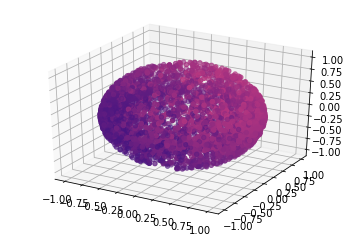

In [5]:
'Perceptron classification, i.e. create y vector'

def sigmoid(x):
    return 1/(1 + np.exp(x))

def random_perceptron(x):
    W = (np.random.rand(n, 1) - 0.5) * 1.5
    b = (np.random.rand(1) - 0.5) * 1.5

    return sigmoid(x.dot(W) + b)

y = random_perceptron(x)

'Visualize first 3 dimensions of x, y is the color'

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], c = [(float(i),float(i) * 0.3,0.5) for i in y])


In [6]:
'Convert numpy to torch tensors, create train and test set'
x = torch.from_numpy(x)
y = torch.from_numpy(y)
x,y = x.type(torch.FloatTensor),y.type(torch.FloatTensor)

train_input, train_target = Variable(x[:int(input_size*0.7), :]), Variable(y[:int(input_size*0.7)])
test_input, test_target = Variable(x[int(input_size*0.7):, :]), Variable(y[int(input_size*0.7):])

In [ ]:
'Given histogram matrix (num of hidden layers) x (num bins)'
'gives mutual information as sum on of the entropy of each unit in hidden layer'

def mutual_info(hist, nb_units):
    MI = 0
    for i in range(nb_units):
        p = hist[i,:] / np.sum(np.sum(hist[i,:])) + 1e-8 # add sth small to avoid Nan in log
        MI -= np.sum(np.multiply(p, np.log(p)))   #MI = H(Y) - H(Y|X) = H(Y)
        
    return MI

def plot_hist(hist, nb_bins, nb_units):
    
    fig, axes = plt.subplots(nrows = nb_units // 3, ncols = 3, sharex = True, sharey = True, squeeze = False)
    fig.suptitle("Activity histograms of single neurons")
    for i in range(nb_units):
        #axes[i // 3, i % 3].set_title(str(i))
        axes[i // 3, i % 3].set_xticklabels([0,0,0.5,1])
        axes[i // 3, i % 3].set_yticklabels([])
        axes[i // 3, i % 3].bar(range(nb_bins), hist[i,:])

In [ ]:
'Training'

nb_hidden = 30
nb_bins = 50    #Bins for mutual information estimation
nb_epochs = 5000


model, criterion = Net(nb_hidden), nn.MSELoss()
eta, mini_batch_size = 1e-1, 100

MI_hidden = np.zeros((nb_epochs,))
MI_output = np.zeros((nb_epochs,))

for e in range(0, nb_epochs):
    sum_loss = 0
    hist_hidden = np.zeros((nb_hidden, nb_bins)) #create histogram to store occurrance of each hidden node value in each bin
    hist_output = np.zeros((1, nb_bins)) 
    
    # We do this with mini-batches
    for b in range(0, train_input.size(0), mini_batch_size):
        t, output = model.forward(train_input.narrow(0, b, mini_batch_size))
        loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
        sum_loss = sum_loss + loss.data[0]
        model.zero_grad()
        loss.backward()
        for p in model.parameters():
            p.data.sub_(eta * p.grad.data)
        
        #Divide output of hidden layer into bins for one epoch, hist has 20
        hist_hidden += np.array([np.histogram(s, bins = nb_bins)[0] for s in t.data.numpy().T])
        hist_output += np.array(np.histogram(output.data.numpy(), bins = nb_bins)[0])
        
    MI_hidden[e] = mutual_info(hist_hidden, nb_hidden)
    MI_output[e] = mutual_info(hist_output, 1)
    
    print(e, sum_loss)

0 0.5225197244435549
1 0.44830992445349693
2 0.3898173598572612
3 0.34152340702712536
4 0.30107686668634415
5 0.2671184940263629
6 0.23865577764809132
7 0.21479797270148993
8 0.19472748041152954
9 0.17777031078003347
10 0.16331771528348327
11 0.15084933210164309
12 0.13993276073597372
13 0.1302544951904565
14 0.12156669003888965
15 0.11367573752067983
16 0.10644788830541074
17 0.09977878886274993
18 0.09359536343254149
19 0.08783385623246431
20 0.08244364324491471
21 0.07739759504329413
22 0.0726677606580779
23 0.06822849169839174
24 0.06406143796630204
25 0.06015414954163134
26 0.05649066693149507
27 0.05305885570123792
28 0.049845704110339284
29 0.04684191127307713
30 0.04403409647056833
31 0.04141490423353389
32 0.03897230053553358
33 0.03669714875286445
34 0.03457854373846203
35 0.032609989517368376
36 0.030781201843637973
37 0.029082885943353176
38 0.02750635042320937
39 0.026043394405860454
40 0.02468491590116173
41 0.023424406012054533
42 0.022254331852309406
43 0.02116940022096

330 0.0022553712042281404
331 0.002251715905003948
332 0.002248073687951546
333 0.002244443370727822
334 0.0022408231561712455
335 0.0022372155435732566
336 0.0022336194779200014
337 0.0022300350465229712
338 0.0022264639228524175
339 0.0022229026471904945
340 0.002219354973931331
341 0.0022158187130116858
342 0.0022122922600829042
343 0.002208777234045556
344 0.002205271001002984
345 0.002201771829277277
346 0.002198283764300868
347 0.002194805954786716
348 0.0021913390410190914
349 0.0021878843872400466
350 0.002184442098950967
351 0.0021810111629747553
352 0.0021775863933726214
353 0.002174170149373822
354 0.0021707640826207353
355 0.002167368773370981
356 0.0021639833412336884
357 0.002160607520636404
358 0.0021572405203187373
359 0.00215388132892258
360 0.0021505313634406775
361 0.002147190200048499
362 0.0021438590993057005
363 0.0021405364022939466
364 0.0021372227874962846
365 0.0021339193554013036
366 0.002130621591277304
367 0.0021273313723213505
368 0.002124052138242405
369 

649 0.0014330152025650023
650 0.001431149063137127
651 0.0014292860741988989
652 0.0014274252353061456
653 0.0014255666246754117
654 0.0014237120140023762
655 0.0014218614669516683
656 0.0014200134010025067
657 0.0014181688584358199
658 0.0014163272808218608
659 0.001414487471265602
660 0.0014126510850474006
661 0.0014108194300206378
662 0.0014089919368416304
663 0.0014071660334593616
664 0.0014053418963158038
665 0.001403519274390419
666 0.0014016987988725305
667 0.0013998801023262786
668 0.001398064192471793
669 0.0013962514058221132
670 0.001394442389937467
671 0.001392636801028857
672 0.0013908335968153551
673 0.001389033073792234
674 0.0013872378931409912
675 0.0013854466633347329
676 0.0013836558646289632
677 0.0013818670086038765
678 0.0013800785782223102
679 0.0013782916594209382
680 0.001376507065288024
681 0.0013747251887252787
682 0.0013729474194406066
683 0.0013711738884012448
684 0.0013694035405933391
685 0.0013676376220246311
686 0.0013658748994203052
687 0.00136411469793

969 0.0009669085029599955
970 0.0009657930295361439
971 0.0009646789349062601
972 0.0009635681781219319
973 0.0009624594404158415
974 0.000961353063757997
975 0.0009602487334632315
976 0.0009591470843588468
977 0.0009580466539773624
978 0.0009569479952915572
979 0.0009558510391798336
980 0.000954756620558328
981 0.0009536648813082138
982 0.0009525753575871931
983 0.0009514877365290886
984 0.000950402747548651
985 0.0009493197649135254
986 0.0009482377026870381
987 0.0009471578505326761
988 0.0009460794790356886
989 0.0009450028483115602
990 0.0009439272344025085
991 0.0009428533521713689
992 0.0009417813289473997
993 0.0009407110228494275
994 0.0009396429268235806
995 0.0009385779612784972
996 0.0009375151166750584
997 0.0009364542474941118
998 0.000935395428314223
999 0.0009343385499960277
1000 0.0009332839144917671
1001 0.0009322315654571867
1002 0.0009311822905146983
1003 0.0009301342088292586
1004 0.000929087511394755
1005 0.0009280418471462326
1006 0.0009269981892430224
1007 0.000

1275 0.0006996723905103863
1276 0.000698990539603983
1277 0.0006983099392527947
1278 0.0006976291178943939
1279 0.0006969441074033966
1280 0.0006962583547647228
1281 0.0006955739791010274
1282 0.0006948906438992708
1283 0.0006942085092305206
1284 0.0006935268111192272
1285 0.000692845893354388
1286 0.0006921660215084557
1287 0.00069148731927271
1288 0.0006908101340741268
1289 0.000690137308993144
1290 0.0006894649413879961
1291 0.000688794148118177
1292 0.0006881246281409403
1293 0.0006874558275740128
1294 0.0006867883585073287
1295 0.000686121653416194
1296 0.0006854554894744069
1297 0.0006847905160611845
1298 0.000684126182932232
1299 0.0006834634641563753
1300 0.0006828019450040301
1301 0.0006821423112342018
1302 0.0006814844191467273
1303 0.0006808274783907109
1304 0.000680171414387587
1305 0.0006795167573727667
1306 0.0006788622822568868
1307 0.0006782083446523757
1308 0.0006775541814931785
1309 0.0006769010778953088
1310 0.0006762482071280829
1311 0.0006755957456334727
1312 0.000

1581 0.0005330474505171878
1582 0.0005326232267179876
1583 0.0005322003489709459
1584 0.0005317778322933009
1585 0.0005313564224707079
1586 0.0005309358230078942
1587 0.0005305157410475658
1588 0.0005300962639012141
1589 0.0005296774988892139
1590 0.0005292589685268467
1591 0.0005288409474815126
1592 0.0005284231938276207
1593 0.0005280053565002163
1594 0.0005275886151139275
1595 0.00052717225116794
1596 0.0005267568594717886
1597 0.000526342789271439
1598 0.0005259296876829467
1599 0.0005255167861832888
1600 0.0005251048833088134
1601 0.0005246934251772473
1602 0.0005242832212388748
1603 0.0005238734793238109
1604 0.0005234646605458693
1605 0.0005230560363997938
1606 0.0005226471166679403
1607 0.0005222391364441137
1608 0.0005218318374318187
1609 0.0005214247794356197
1610 0.0005210179479036015
1611 0.0005206109281061799
1612 0.0005202042520977557
1613 0.0005197986047278391
1614 0.0005193933393456973
1615 0.0005189888406675891
1616 0.0005185843547224067
1617 0.000518181172083132
1618 

1883 0.000426854131546861
1884 0.00042656829555198783
1885 0.00042628237042663386
1886 0.0004259971656210837
1887 0.0004257124501236831
1888 0.00042542758001218317
1889 0.0004251418577041477
1890 0.0004248563755027135
1891 0.00042457122526684543
1892 0.00042428580309206154
1893 0.00042400099573569605
1894 0.00042371665222162846
1895 0.0004234328425809508
1896 0.0004231496168358717
1897 0.00042286698408133816
1898 0.00042258488792867865
1899 0.00042230309190927073
1900 0.0004220210312269046
1901 0.0004217391488055
1902 0.00042145775478275027
1903 0.0004211771010886878
1904 0.00042089642465725774
1905 0.00042061643216584343
1906 0.00042033674890262773
1907 0.00042005819432233693
1908 0.0004197797343294951
1909 0.000419502467593702
1910 0.00041922541640815325
1911 0.0004189485180177144
1912 0.00041867173422360793
1913 0.0004183953205938451
1914 0.0004181190270173829
1915 0.0004178427379883942
1916 0.0004175667927484028
1917 0.00041729062468220945
1918 0.00041701431746332673
1919 0.0004167

2182 0.0003569268355931854
2183 0.0003567379976630036
2184 0.000356549569460185
2185 0.000356361459580512
2186 0.0003561738599273667
2187 0.00035598653676061076
2188 0.0003557996897143312
2189 0.00035561296454034164
2190 0.0003554267432264169
2191 0.0003552410644260817
2192 0.00035505525875123567
2193 0.0003548701724866987
2194 0.00035468562919049873
2195 0.00035450133373160497
2196 0.0003543175153026823
2197 0.0003541339478942973
2198 0.0003539508029462013
2199 0.0003537681327543396
2200 0.0003535857554197719
2201 0.00035340343674761243
2202 0.0003532205810188316
2203 0.0003530378035065951
2204 0.00035285538297102903
2205 0.000352673447196139
2206 0.000352491796547838
2207 0.0003523106338434445
2208 0.00035212989860156085
2209 0.00035194927659176756
2210 0.0003517690929584205
2211 0.0003515891935421678
2212 0.00035140955878887326
2213 0.00035123031193506904
2214 0.0003510513142828131
2215 0.00035087283640677924
2216 0.0003506941261548491
2217 0.0003505154641061381
2218 0.0003503374350

2482 0.00031081832048585056
2483 0.00031069358192326035
2484 0.0003105688151663344
2485 0.00031044410661706934
2486 0.00031031969183459296
2487 0.00031019542529975297
2488 0.0003100711492152186
2489 0.0003099472182839236
2490 0.0003098231950389163
2491 0.00030969942190495203
2492 0.00030957591934566153
2493 0.00030945234811952105
2494 0.00030932941126593505
2495 0.00030920624567443156
2496 0.00030908260714568314
2497 0.00030895923964635585
2498 0.0003088356947955617
2499 0.0003087116551796498
2500 0.0003085873845520837
2501 0.0003084634945480502
2502 0.00030833925666229334
2503 0.00030821535119684995
2504 0.00030809128566033905
2505 0.00030796767578067374
2506 0.00030784431282881997
2507 0.00030772117634114693
2508 0.0003075982936024957
2509 0.0003074752416978299
2510 0.000307352203890332
2511 0.00030722938981853076
2512 0.00030710678993273177
2513 0.0003069843178309384
2514 0.0003068621908823843
2515 0.0003067401125917968
2516 0.00030661831942779827
2517 0.00030649675954919076
2518 0.

2782 0.0002779461565296515
2783 0.00027785264637714135
2784 0.00027775909984484315
2785 0.00027766568837250816
2786 0.0002775724406092195
2787 0.0002774793338176096
2788 0.00027738619110095897
2789 0.0002772932161860808
2790 0.000277200439995795
2791 0.0002771076046883536
2792 0.000277014928542485
2793 0.0002769223819996114
2794 0.0002768299336821656
2795 0.00027673781869452796
2796 0.0002766455900200526
2797 0.0002765536582955974
2798 0.00027646175294648856
2799 0.00027636988897938863
2800 0.00027627835697785486
2801 0.0002761868277048052
2802 0.0002760954894256429
2803 0.00027600407656791504
2804 0.0002759128451543802
2805 0.00027582180928220623
2806 0.00027573091165322694
2807 0.00027564031506699394
2808 0.0002755496170721017
2809 0.00027545933653527754
2810 0.0002753689614110044
2811 0.0002752788027464703
2812 0.0002751887504928163
2813 0.0002750992098299321
2814 0.00027501012345965137
2815 0.00027492115214045043
2816 0.0002748314836935606
2817 0.0002747420999185124
2818 0.00027465

3082 0.00025309009060947574
3083 0.00025301746836703387
3084 0.0002529443777348206
3085 0.0002528707714191114
3086 0.00025279736746597337
3087 0.00025272403172493796
3088 0.00025265081194447703
3089 0.00025257771130782203
3090 0.0002525045601942111
3091 0.00025243140225938987
3092 0.00025235803241230315
3093 0.00025228496951967827
3094 0.0002522120248613646
3095 0.00025213955086655915
3096 0.0002520670295780292
3097 0.00025199465426339884
3098 0.000251922291226947
3099 0.00025185002596117556
3100 0.00025177807447107625
3101 0.0002517060111131286
3102 0.0002516341560294677
3103 0.000251562461926369
3104 0.000251490907430707
3105 0.000251419412506948
3106 0.00025134792895187275
3107 0.00025127668550339877
3108 0.0002512055957595294
3109 0.000251134281825216
3110 0.00025106289740506327
3111 0.00025099173126363894
3112 0.00025092056466746726
3113 0.0002508493939785694
3114 0.00025077835880438215
3115 0.0002507076937945385
3116 0.00025063661860258435
3117 0.00025056606682483107
3118 0.00025

3380 0.00023338475102718803
3381 0.00023332542059506522
3382 0.0002332660765205219
3383 0.0002332067256247683
3384 0.0002331474561287905
3385 0.0002330882211936114
3386 0.00023302922272705473
3387 0.00023297033840208314
3388 0.00023291125989999273
3389 0.0002328524778931751
3390 0.00023279377001017565
3391 0.0002327350780433335
3392 0.0002326759899915487
3393 0.0002326173844267032
3394 0.0002325586715414829
3395 0.00023250002050190233
3396 0.00023244138174050022
3397 0.00023238285029947292
3398 0.00023232429111885722
3399 0.00023226584153235308
3400 0.0002322074210496794
3401 0.0002321491274415166
3402 0.0002320909989066422
3403 0.00023203295859275386
3404 0.0002319747109140735
3405 0.00023191677064460237
3406 0.00023185867257780046
3407 0.0002318008778274816
3408 0.0002317430676157528
3409 0.00023168545703811105
3410 0.0002316277946192713
3411 0.00023157006171459216
3412 0.00023151264713305864
3413 0.00023145543491409626
3414 0.00023139800714488956
3415 0.00023134082402975764
3416 0.0

3676 0.00021774364131488255
3677 0.000217694671391655
3678 0.00021764587063444196
3679 0.0002175971776523511
3680 0.00021754835734100197
3681 0.00021749951565652736
3682 0.00021745082131019444
3683 0.00021740235251854756
3684 0.0002173539537579927
3685 0.00021730555999965873
3686 0.00021725713440901018
3687 0.00021720866789110005
3688 0.0002171603441638581
3689 0.00021711198451157543
3690 0.00021706380357500166
3691 0.00021701538616980542
3692 0.00021696703515772242
3693 0.00021691902384191053
3694 0.00021687080106858048
3695 0.00021682272063117125
3696 0.00021677487075066892
3697 0.00021672701132047223
3698 0.000216679060486058
3699 0.0002166307335755846
3700 0.0002165825094380125
3701 0.00021653456360581913
3702 0.0002164865009035566
3703 0.00021643851414410165
3704 0.00021639053238686756
3705 0.00021634232052747393
3706 0.00021629418597512995
3707 0.00021624633609462762
3708 0.0002161984334634326
3709 0.0002161506204174657
3710 0.0002161027850888786
3711 0.0002160549829568481
3712 0

3972 0.00020434680800462957
3973 0.000204304383487397
3974 0.0002042618841642252
3975 0.00020421923682079068
3976 0.00020417663972693845
3977 0.00020413360971360817
3978 0.00020409062790349708
3979 0.0002040476949787262
3980 0.00020400487574079307
3981 0.00020396191666804953
3982 0.0002039190833329485
3983 0.00020387603808558197
3984 0.000203833042178303
3985 0.00020378993599479145
3986 0.00020374704058667703
3987 0.00020370410106806958
3988 0.00020366118474157702
3989 0.00020361822339509672
3990 0.0002035753852851485
3991 0.0002035323443578818
3992 0.00020348958332760958
3993 0.0002034469764566893
3994 0.00020340421951914323
3995 0.00020336175975899096
3996 0.00020331912651272432
3997 0.0002032766747106507
3998 0.0002032342781603802
3999 0.00020319201985330437
4000 0.00020314974017310305
4001 0.00020310743843765522
4002 0.00020306518172219512
4003 0.0002030230864420446
4004 0.0002029809388659487
4005 0.0002029386766935204
4006 0.00020289669828343904
4007 0.00020285443338252662
4008 0.

4268 0.00019265641185484128
4269 0.0001926204167830292
4270 0.00019258444854131085
4271 0.00019254843869020988
4272 0.00019251245453233423
4273 0.0001924764194427553
4274 0.00019244040072408097
4275 0.00019240429423916794
4276 0.0001923679089941288
4277 0.00019233169564358832
4278 0.00019229547069699038
4279 0.000192259269169881
4280 0.00019222303899368853
4281 0.00019218689521949273
4282 0.00019215055863242014
4283 0.00019211429798815516
4284 0.00019207811897103966
4285 0.00019204177897336194
4286 0.0001920056188282615
4287 0.00019196938319510082
4288 0.00019193334287592734
4289 0.0001918973587180517
4290 0.0001918612035751721
4291 0.0001918253246913082
4292 0.00019178935804120556
4293 0.00019175346074007393
4294 0.00019171751114299695
4295 0.0001916814642299869
4296 0.00019164535410709505
4297 0.0001916091912335105
4298 0.00019157318092766218
4299 0.00019153727430420986
4300 0.0001915009531785472
4301 0.00019146493605148862
4302 0.00019142857127008028
4303 0.00019139247865496145
4304

In [ ]:
'Plot last epoch histograms for MI'

plot_hist(hist_hidden, nb_bins, nb_hidden)
#print(MI_hidden)

#plot_hist(hist_output, nb_bins, 1)
#print(MI_output)

plt.figure("Information plane", figsize = (10,6))
plt.title("Information plane with " + str(nb_epochs) + " epochs, " + str(nb_hidden) + " hidden units, " + str(nb_bins) + "bins")
plt.grid(True)
plt.xlabel("$I(T|X)$")
plt.ylabel("$I(Y|X)$")

plt.scatter(MI_hidden, MI_output, c = range(nb_epochs), cmap = "tab20c")
plt.colorbar()

plt.savefig("information_plane_" + str(nb_epochs) + "epochs.png" + str(nb_hidden) + "hidden_units_relu.png")


In [ ]:
'Computing loss on test data'

_, output = model.forward(test_input)

mse = (torch.norm(output - test_target)).mean()
loss = criterion(output, test_target)

print("MSE = ", float(loss), float(mse))

In [ ]:
'Other n-sphere_OLD'

n = 4
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')

for i in range(1000):
    color = 'g'
    alpha = np.pi * np.random.rand(n - 2)
    alpha[-1] = 2* alpha[-1]

    x = rand_n_sphere(1, alpha)
        
    if x[0] > 0 and x[1] < 0.5 and x[1] > -0.2 or x[2] < -0.4: 
        color = "b" 
    ax.scatter(x[0], x[1], x[2], c = (0.6,0,y))

plt.show()